In [1]:
import time

import imageio
import collections

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

%matplotlib inline

In [2]:
def animate(mass, position):
    image = np.zeros((1024, 1024))
    position = np.round(position).astype(np.int32)
    mass = mass.astype(np.int32)
        
    for i in range(len(mass)):
        temp_position = position[i]
        temp_mass = mass[i][0]

        image[np.maximum(temp_position[0] - temp_mass//2, 0) : np.minimum(temp_position[0] + temp_mass//2, 1024), 
              np.maximum(temp_position[1] - temp_mass//2, 0) : np.minimum(temp_position[1] + temp_mass//2, 1024)] = 255
        image = np.uint8(np.clip(image, 0, 255))
    
    file = BytesIO()
    PIL.Image.fromarray(image).save(file, 'jpeg')
    clear_output(wait = True)
    display(Image(data=file.getvalue()))

    return image

In [3]:
DIMENSIONS = 2

In [4]:
m = np.array([[10], [20], [2]])
x = np.array([[1, 2], [2, 4], [1, 4]])
x = x[:, None, :]

r = x.transpose(1, 0, 2) - x

f = np.multiply(m.T, m) - np.diag(m.reshape((-1)) ** 2)
f = f / np.power(np.sum(np.square(r), axis=2), 3)

r_hat = r / np.sum(np.square(r), axis=2, keepdims=True)
f = np.nansum(np.multiply(f[:, :, None], r_hat), axis=0)

f

/home/bhagyesh/envs/research/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/bhagyesh/envs/research/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


array([[ -0.32   ,  -0.79625],
       [ 40.32   ,   0.64   ],
       [-40.     ,   0.15625]])

In [5]:
f_initial = tf.placeholder(shape=[None, DIMENSIONS], dtype=tf.float32)
v_initial = tf.placeholder(shape=[None, DIMENSIONS], dtype=tf.float32)
x_initial = tf.placeholder(shape=[None, DIMENSIONS], dtype=tf.float32)

force = tf.Variable(f_initial, dtype=tf.float32, validate_shape=False)

m = tf.placeholder(shape=[None, 1], dtype=tf.float32)

G = tf.constant(6.67259, dtype=tf.float32)

acceleration = tf.Variable(tf.zeros_like(f_initial), validate_shape=False)
velocity = tf.Variable(v_initial, dtype=tf.float32, validate_shape=False)
position = tf.Variable(x_initial, dtype=tf.float32, validate_shape=False)

t_h = tf.placeholder(shape=[], dtype=tf.float32)
t_s = tf.placeholder(shape=[], dtype=tf.int32)

t = tf.Variable(0, dtype=tf.int32)

In [6]:
is_collide = tf.logical_or(position < m / 2.0, position > 1024 - m / 2.0)

x = tf.expand_dims(position, axis=1)

r = x - tf.transpose(x, perm=[1, 0, 2])
r_magnitude = tf.sqrt(tf.reduce_sum(tf.square(r), axis=2, keepdims=True))
r_hat = r / r_magnitude

f = tf.matmul(tf.transpose(m), m) * G
f = tf.multiply(tf.expand_dims(f, axis=2), r_hat)
f = f / tf.square(r_magnitude)

f = tf.where(tf.is_nan(f), tf.zeros_like(f), f)
f = tf.reduce_sum(f, axis=0)

f_ = f * tf.pow(-1.0, tf.cast(is_collide, dtype=tf.float32))

a_ = f_ / m

v_ = velocity * tf.pow(-1.0, tf.cast(is_collide, dtype=tf.float32)) + a_ * t_h

x_ = position + v_ * t_h

step = tf.group(force.assign(f_), 
                acceleration.assign(a_), 
                velocity.assign(v_), 
                position.assign(x_))

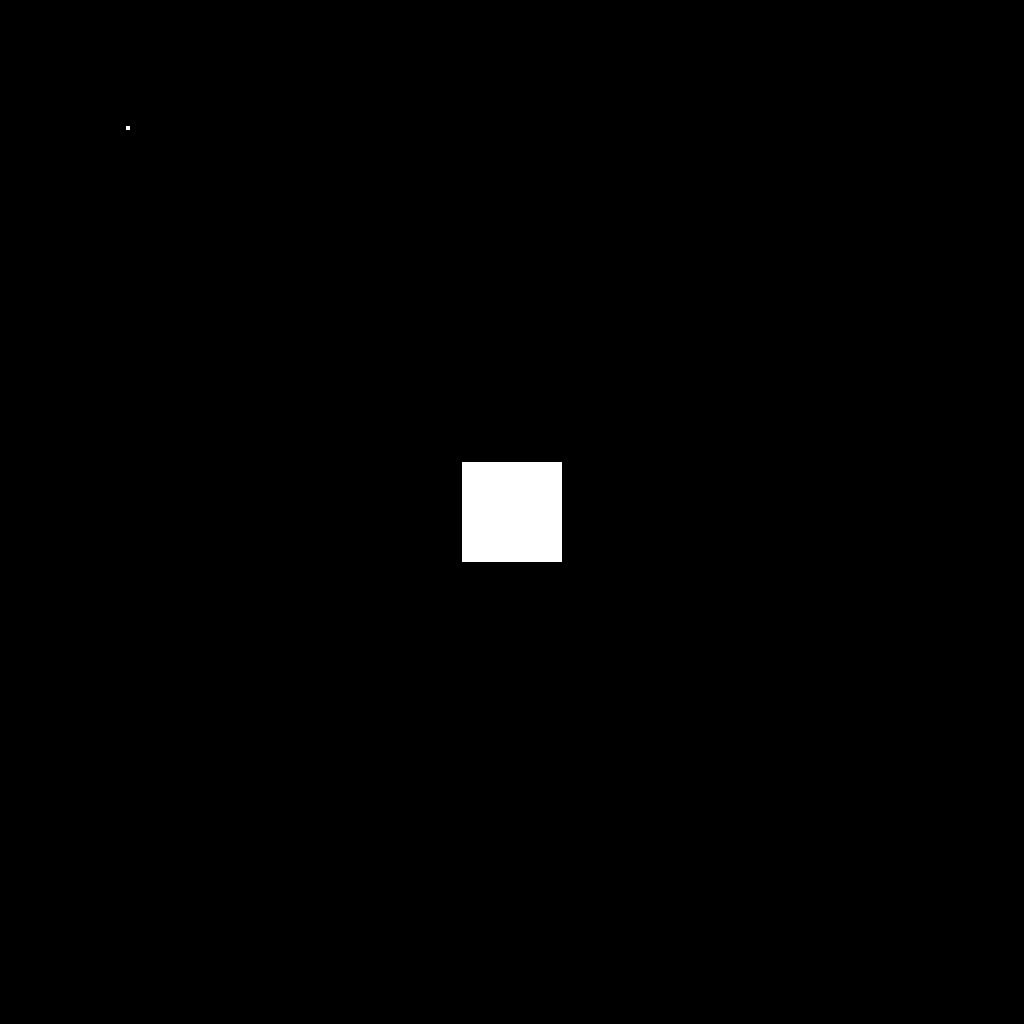

50.688074827194214


In [7]:
start_time = time.time()

force_0 = np.array([[0.0, 0.0], [0.0, 0.0]], dtype=np.float32)
velocity_0 = np.array([[0.0, 0.0], [0.1, 0.1]], dtype=np.float32)
position_0 = np.array([[512, 512], [128, 128]])

mass = np.array([[100], [5]])
time_horizon = 1
number_horizon = int(1000 / time_horizon)

gif_frames = []

with tf.Session() as sess:
    for i in range(number_horizon):
        sess.run(tf.global_variables_initializer(), 
                 feed_dict={f_initial:force_0, 
                            v_initial:velocity_0, 
                            x_initial:position_0})
        sess.run(step, feed_dict={m:mass, t_h:time_horizon, t_s:i})
        temp = sess.run([force, position])
        animate(mass, temp[1])
        
execution_time = time.time() - start_time
print(execution_time)